# Note
This code Properly run in google collab

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
# 2. Load dataset
df = pd.read_csv("ToyotaCorollMLR.csv")
df

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170
...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,Petrol,86,0,1300,3,4,5,1025
1432,10845,72,19000,Petrol,86,0,1300,3,4,5,1015
1433,8500,71,17016,Petrol,86,0,1300,3,4,5,1015
1434,7250,70,16916,Petrol,86,0,1300,3,4,5,1015


              Price    Age_08_04             KM           HP    Automatic  \
count   1436.000000  1436.000000    1436.000000  1436.000000  1436.000000   
mean   10730.824513    55.947075   68533.259749   101.502089     0.055710   
std     3626.964585    18.599988   37506.448872    14.981080     0.229441   
min     4350.000000     1.000000       1.000000    69.000000     0.000000   
25%     8450.000000    44.000000   43000.000000    90.000000     0.000000   
50%     9900.000000    61.000000   63389.500000   110.000000     0.000000   
75%    11950.000000    70.000000   87020.750000   110.000000     0.000000   
max    32500.000000    80.000000  243000.000000   192.000000     1.000000   

                cc        Doors  Cylinders        Gears      Weight  
count   1436.00000  1436.000000     1436.0  1436.000000  1436.00000  
mean    1576.85585     4.033426        4.0     5.026462  1072.45961  
std      424.38677     0.952677        0.0     0.188510    52.64112  
min     1300.00000     2.0

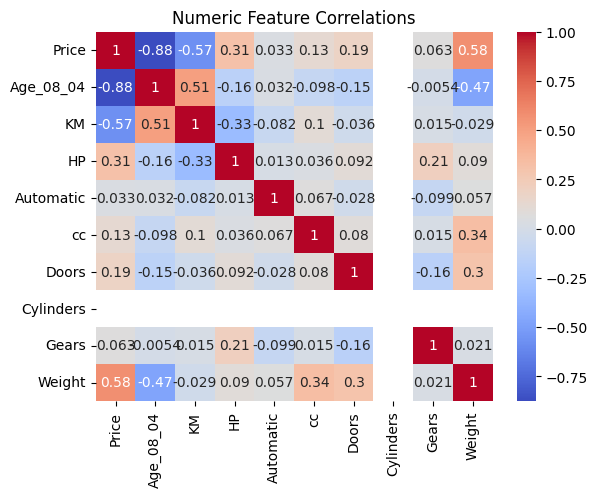

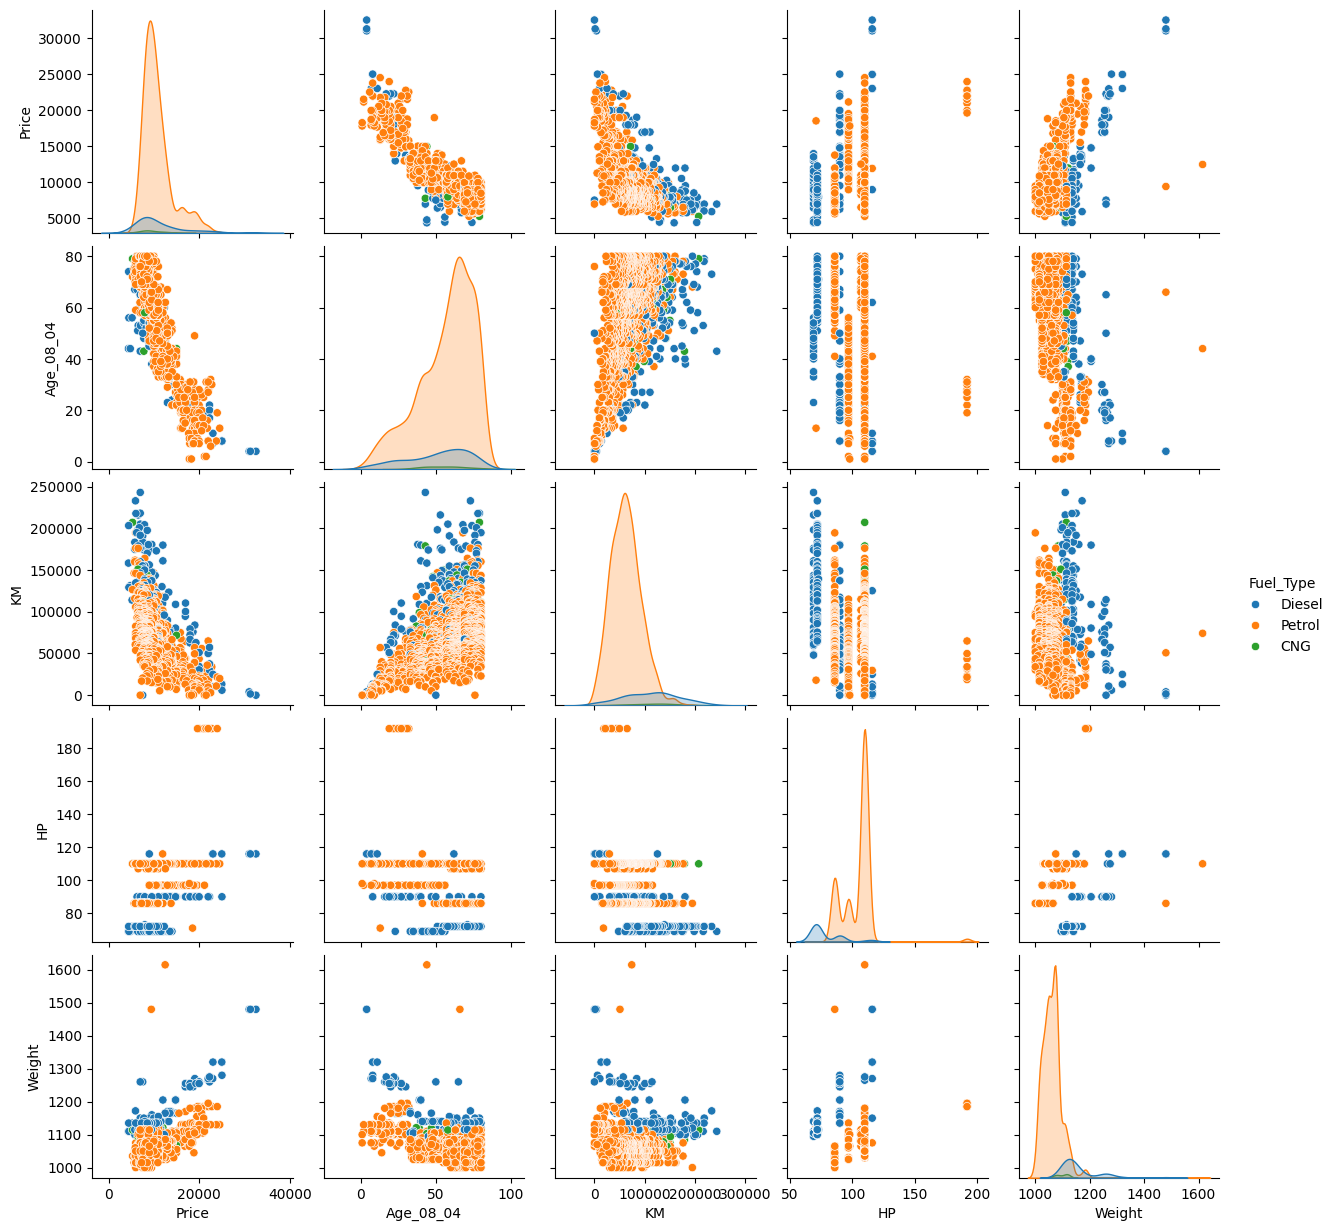

In [5]:
# 3. EDA & Visualizations
print(df.describe())
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Numeric Feature Correlations")
plt.show()
sns.pairplot(df, vars=['Price', 'Age_08_04', 'KM', 'HP', 'Weight'], hue='Fuel_Type')
plt.show()

In [6]:
# 4. Preprocessing setup
num_features = ['Age_08_04', 'KM', 'HP', 'cc', 'Doors', 'Weight']
cat_features = ['Fuel_Type', 'Automatic']
target = 'Price'

In [7]:
# 5. Split data first (80/20)
X = df[num_features + cat_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 6. Build preprocessing pipeline (Standardize + OneHot)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)
])


In [9]:
# 7. Fit and transform training data only (no leakage!)
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [10]:
# 8. VIF calculation on X_train
def compute_vif(X, feature_names):
    vif_data = pd.DataFrame()
    vif_data["feature"] = feature_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif_data

feature_names = (
    num_features +
    list(preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features))
)
X_vif = pd.DataFrame(X_train_prep, columns=feature_names)
vif_table = compute_vif(X_vif, feature_names)
print("\nVIF Table (train set only):")
print(vif_table)


VIF Table (train set only):
            feature       VIF
0         Age_08_04  1.951328
1                KM  1.933704
2                HP  2.324720
3                cc  1.193322
4             Doors  1.177400
5            Weight  3.854537
6  Fuel_Type_Diesel  4.352867
7  Fuel_Type_Petrol  1.611428
8       Automatic_1  1.172120


In [11]:
# 9. Model 1: All features (baseline)
model1 = LinearRegression().fit(X_train_prep, y_train)
y_pred1 = model1.predict(X_test_prep)
print("\nModel 1 Metrics (All Features):")
print(f"MSE: {mean_squared_error(y_test, y_pred1):.2f}")
print(f"R2: {r2_score(y_test, y_pred1):.2f}")


Model 1 Metrics (All Features):
MSE: 2224306.04
R2: 0.83


In [12]:
# 10. Check p-values + standardized coefficients on Model1 (using statsmodels)
X_train_sm = sm.add_constant(X_train_prep)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print("\nModel 1 Coefficients + P-values:")
coef_table = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coef': ols_model.params,
    'P-value': ols_model.pvalues
})
print(coef_table)


Model 1 Coefficients + P-values:
                Feature         Coef        P-value
const         Intercept  9481.098641  1.048850e-137
x1            Age_08_04 -2267.156303  9.704222e-232
x2                   KM  -600.179991   3.668899e-26
x3                   HP   234.138332   8.004426e-05
x4                   cc   -14.098311   7.392799e-01
x5                Doors   -80.500836   5.594648e-02
x6               Weight  1326.190352   3.019080e-60
x7     Fuel_Type_Diesel     4.202110   9.914434e-01
x8     Fuel_Type_Petrol  1453.694461   1.596050e-05
x9          Automatic_1    93.081993   5.979149e-01


In [13]:
# 11. Flag weak features: High VIF (>10), high p-value (>0.05), tiny coef
weak_vif = vif_table[vif_table["VIF"] > 10]["feature"].tolist()
weak_p = coef_table[(coef_table["P-value"] > 0.05) & (coef_table["Feature"] != "Intercept")]["Feature"].tolist()
weak_coef = coef_table[(coef_table["Coef"].abs() < 0.05) & (coef_table["Feature"] != "Intercept")]["Feature"].tolist()
flagged_features = set(weak_vif + weak_p + weak_coef)
print("\nFlagged Weak Features:", flagged_features)


Flagged Weak Features: {'cc', 'Fuel_Type_Diesel', 'Automatic_1', 'Doors'}


In [14]:
# 12. Model 2: Interpretation only (flagged features shown, but not removed)
print("\nModel 2: Displaying flagged features (no removal yet)")
print("Flagged features:", flagged_features)


Model 2: Displaying flagged features (no removal yet)
Flagged features: {'cc', 'Fuel_Type_Diesel', 'Automatic_1', 'Doors'}


In [16]:
# 13. Model 3: Remove flagged features & retrain
features_to_keep = [f for f in feature_names if f not in flagged_features]
cols_to_keep_idx = [feature_names.index(f) for f in features_to_keep]
X_train_reduced = X_train_prep[:, cols_to_keep_idx]
X_test_reduced = X_test_prep[:, cols_to_keep_idx]


model3 = LinearRegression().fit(X_train_reduced, y_train)
y_pred3 = model3.predict(X_test_reduced)
print("\nModel 3 Metrics (Reduced Features):")
print(f"MSE: {mean_squared_error(y_test, y_pred3):.2f}")
print(f"R2: {r2_score(y_test, y_pred3):.2f}")


Model 3 Metrics (Reduced Features):
MSE: 2219740.30
R2: 0.83


In [17]:
# VIF after removal
vif_table_reduced = compute_vif(X_train_reduced, features_to_keep)
print("\nVIF Table AFTER feature removal:")
print(vif_table_reduced)



VIF Table AFTER feature removal:
            feature       VIF
0         Age_08_04  1.905212
1                KM  1.655797
2                HP  1.164899
3            Weight  1.478084
4  Fuel_Type_Petrol  1.100622


In [18]:
# 14. Lasso & Ridge Regression (with all features)
ridge = RidgeCV(alphas=np.logspace(-3,3,10), cv=5).fit(X_train_prep, y_train)
lasso = LassoCV(alphas=None, cv=5).fit(X_train_prep, y_train)

print("\nRidge Regression R2:", ridge.score(X_test_prep, y_test))
print("Lasso Regression R2:", lasso.score(X_test_prep, y_test))

print("\nLasso top coefficients:")
coeffs = pd.Series(lasso.coef_, index=feature_names)
print(coeffs.sort_values(ascending=False).head())


Ridge Regression R2: 0.843093919117836
Lasso Regression R2: 0.8510499721560641

Lasso top coefficients:
Weight              948.930372
HP                  387.263088
Fuel_Type_Petrol      0.000000
Doors                 0.000000
cc                   -0.000000
dtype: float64


# SUMMARY
1. Data Loading & EDA
Imports libraries needed for regression analysis and data handling.

Loads the dataset containing car data such as Age, KM, FuelType, HP, Automatic, etc.

Performs Exploratory Data Analysis (EDA):

Describes variable distributions and relationships.

Visualizes numeric variable correlations and feature relationships (e.g., pairplots).

2. Data Preprocessing
Splits dataset into training and test sets (usually 80:20), ensuring no information leakage.

Preprocessing pipeline:

Numerically scales features (using StandardScaler).

One-hot encodes categorical variables (FuelType, Automatic) for model compatibility.

Transforms only the training data for diagnostic analysis.

3. Multicollinearity & Feature Diagnostics
Calculates VIF (Variance Inflation Factor) on training features to check for multicollinearity, which can harm coefficient reliability.

VIF > 5 or 10 flags features suspected of strong intercorrelation.

Fits model and uses statsmodels to extract standardized coefficients and their p-values:

p-values highlight statistically insignificant predictors.

Coefficients (after scaling) show practical effect size.

4. Model Construction and Analysis
Model 1: Baseline regression using all available features, providing initial performance metrics (MSE, R²).

Model 2: Identifies weak/problematic features using VIF, p-value, and small coefficients, helping decide on potential feature removal.

Model 3: Retrains the regression after removing flagged weak/correlated features and compares metrics and VIFs to observe improvements in feature stability.

Interpretation: Coefficients reflect how much each feature contributes to price prediction; removal of weak features improves interpretability and sometimes predictive power.

5. Regularization Techniques
Ridge Regression adds penalty for large coefficients, reducing instability due to multicollinearity.

Lasso Regression can shrink some coefficients to zero, acting as an automatic feature selector.

Both models are fit to the preprocessed data, and their top coefficients and R² scores are reported

# Interview Q&A (short)

Q1: Normalization vs Standardization

Normalization: scales data to [0,1].

Standardization: mean=0, std=1.

Helps when features are in different units → prevents one feature dominating.

Q2: Handling Multicollinearity

Remove one of the correlated features.

Use VIF to detect collinearity.

Apply Ridge/Lasso regularization.

Use PCA to create uncorrelated components.